In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
sns.set_palette('dark')
plt.style.use('bmh')

In [2]:
df = pd.read_csv('../data/listings.csv')

# Amenities

In [3]:
df['amenities'] = df['amenities'].replace('[^a-zA-Z0-9^,]', '', regex=True).apply(lambda x: x.split(','))
df.amenities.head()

0    [TV, CableTV, Wifi, Airconditioning, Kitchen, ...
1    [TV, CableTV, Internet, Wifi, Airconditioning,...
2    [TV, CableTV, Internet, Wifi, Airconditioning,...
3    [TV, CableTV, Wifi, Airconditioning, Kitchen, ...
4    [TV, CableTV, Internet, Wifi, Airconditioning,...
Name: amenities, dtype: object

In [4]:
by_ame = df.groupby('property_type')['amenities'].agg([np.sum, 'count'])
by_ame.head()

,sum,count
property_type,,
Aparthotel,"[TV, CableTV, Internet, Wifi, Airconditioning,...",1
Apartment,"[TV, CableTV, Wifi, Airconditioning, Kitchen, ...",4134
Bed and breakfast,"[Internet, Wifi, Airconditioning, Heating, Smo...",39
Boat,"[TV, Internet, Wifi, Kitchen, Paidparkingoffpr...",20
Boutique hotel,"[TV, CableTV, Wifi, Airconditioning, Kitchen, ...",19


In [5]:
def uniq(x):
    x = set(x)
    x.discard('')
    return x

by_ame['unique_items'] = by_ame['sum'].apply(uniq)
by_ame['num_items'] = by_ame['unique_items'].apply(lambda x: len(x))
by_ame.head()

,sum,count,unique_items,num_items
property_type,,,,
Aparthotel,"[TV, CableTV, Internet, Wifi, Airconditioning,...",1,"{Wifi, Paidparkingoffpremises, Familykidfriend...",26
Apartment,"[TV, CableTV, Wifi, Airconditioning, Kitchen, ...",4134,"{Fixedgrabbarsfortoilet, 24hourcheckin, Microw...",120
Bed and breakfast,"[Internet, Wifi, Airconditioning, Heating, Smo...",39,"{Other, Refrigerator, 24hourcheckin, Dishesand...",64
Boat,"[TV, Internet, Wifi, Kitchen, Paidparkingoffpr...",20,"{Other, Refrigerator, 24hourcheckin, Dishesand...",59
Boutique hotel,"[TV, CableTV, Wifi, Airconditioning, Kitchen, ...",19,"{Roomdarkeningshades, Refrigerator, Dishesands...",65


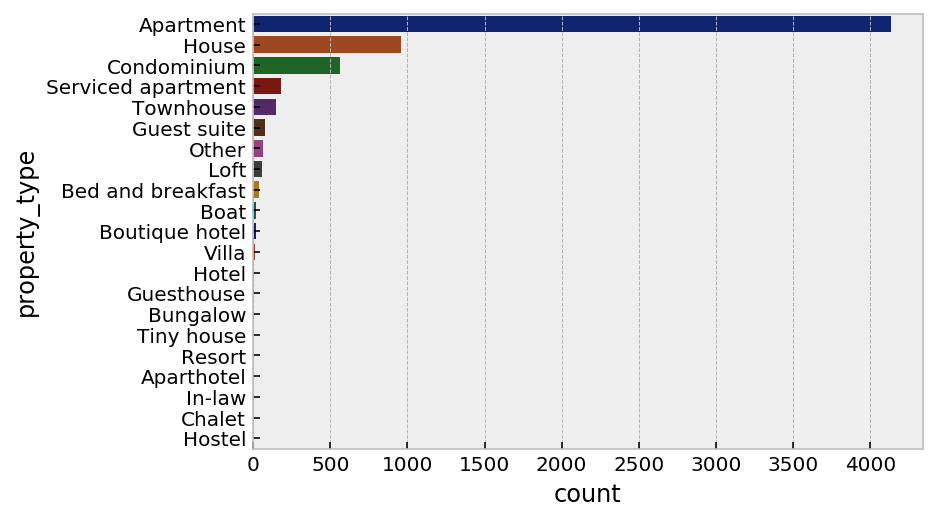

In [6]:
data = by_ame.sort_values('count', ascending=False)
sns.barplot(x=data['count'], y=data.index, palette='dark')

Text(0.5, 1.0, 'Number of amenities listed for each property type')

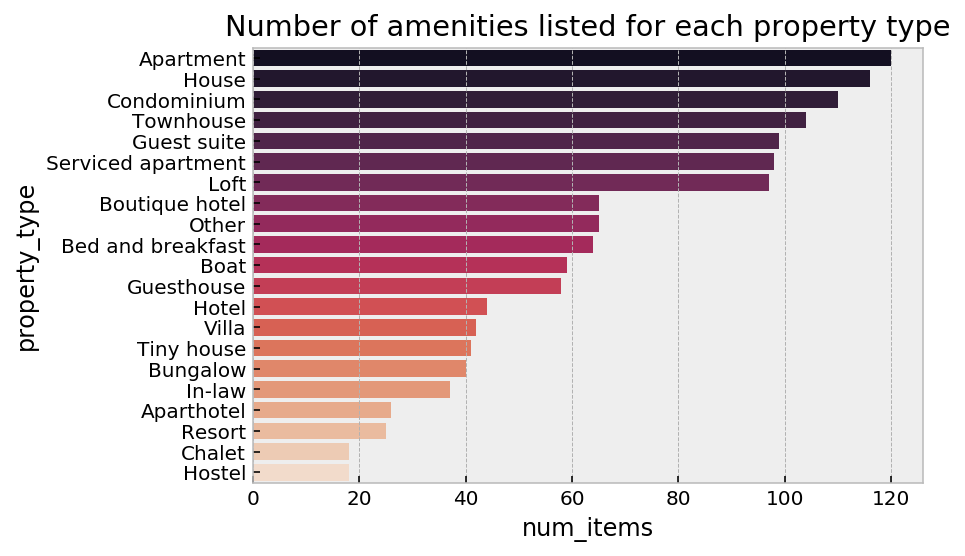

In [7]:
data = by_ame.sort_values('num_items', ascending=False)
sns.barplot(x=data['num_items'], y=data.index, palette='rocket')
plt.title('Number of amenities listed for each property type')

Text(0.5, 1.0, 'Most popular aminities')

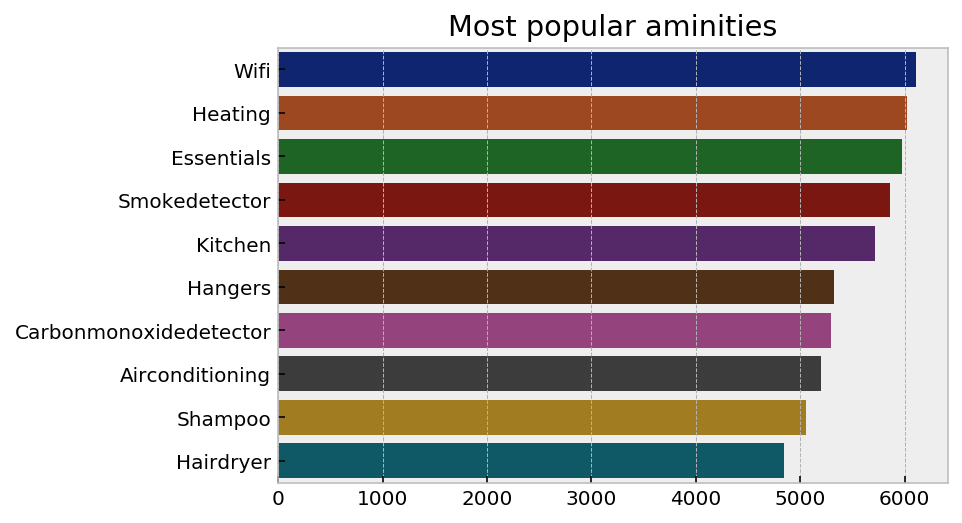

In [8]:
all_items = np.array(np.sum(by_ame['sum']))
all_items = pd.Series(all_items).value_counts()
sns.barplot(all_items[:10].values, all_items[:10].index, palette='dark')
plt.title('Most popular aminities')

In [9]:
def top_k_items(data, k=10, as_perc=False, plot=True, alpha=1):
    top_k = np.array(list(data))
    top_k = pd.Series(top_k).value_counts()[:k]
    if as_perc:
        top_k = top_k / len(data)
    if plot:
        plt.barh(top_k.index, top_k.values, height=0.6, alpha=alpha)
    
    return top_k

top_apartment = top_k_items(by_ame.loc['Apartment', 'sum'], as_perc=True, alpha=0.5)
top_boat = top_k_items(by_ame.loc['Boat', 'sum'], as_perc=True, alpha=0.5)
plt.title('Most popular amenities in Apartment vs. Boat')
plt.legend(['Apartment', 'Boat'])

# Location

In [11]:
df['price'] = df['price'].replace('[^a-zA-Z0-9]', '', regex=True).apply(lambda x: float(x) / 100)
df.price.head()

0    125.0
1    145.0
2    169.0
3     65.0
4     99.0
Name: price, dtype: float64

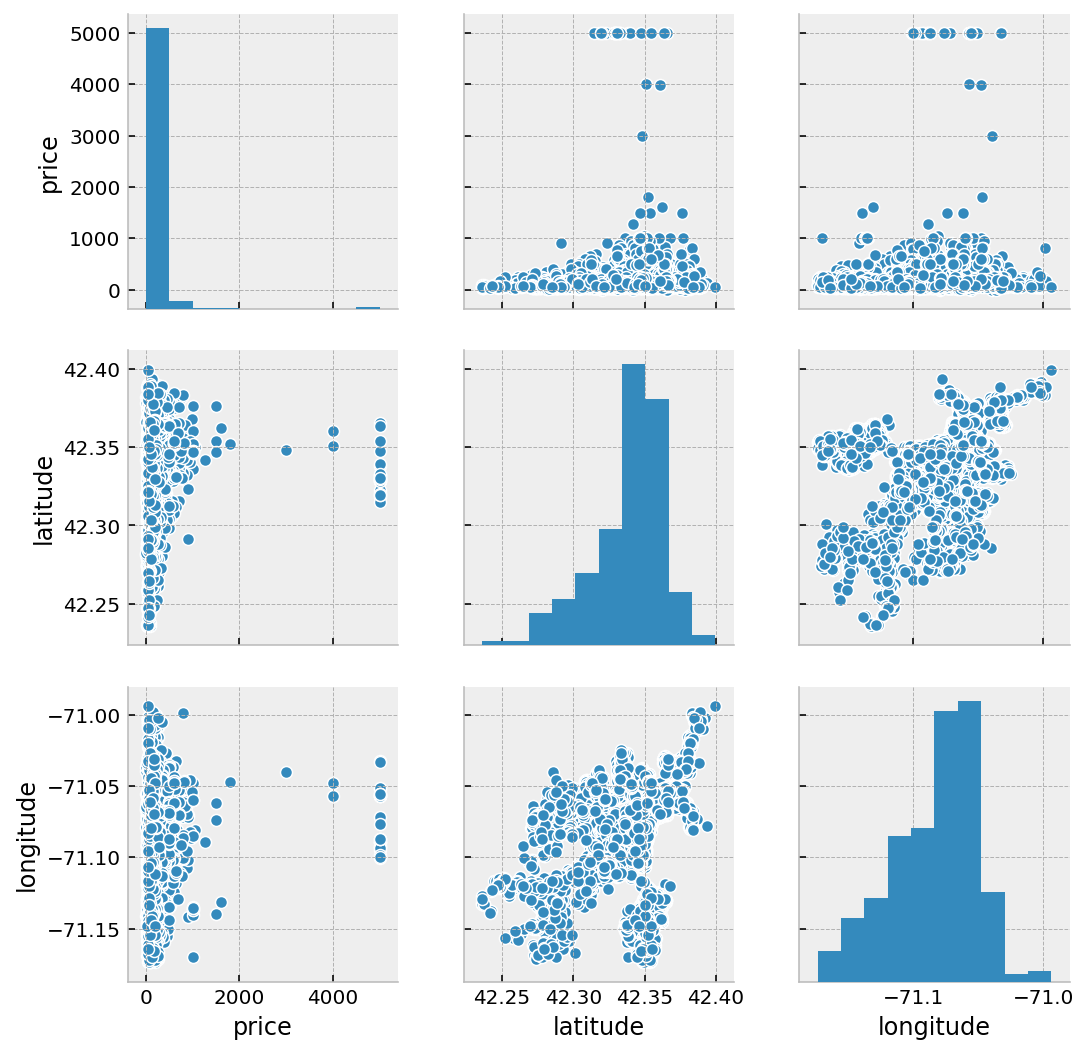

In [12]:
small_df = df[['price', 'latitude', 'longitude']]
sns.pairplot(small_df, palette='dark')

Text(0.5, 1.0, 'Price by Latitude and Longitude')

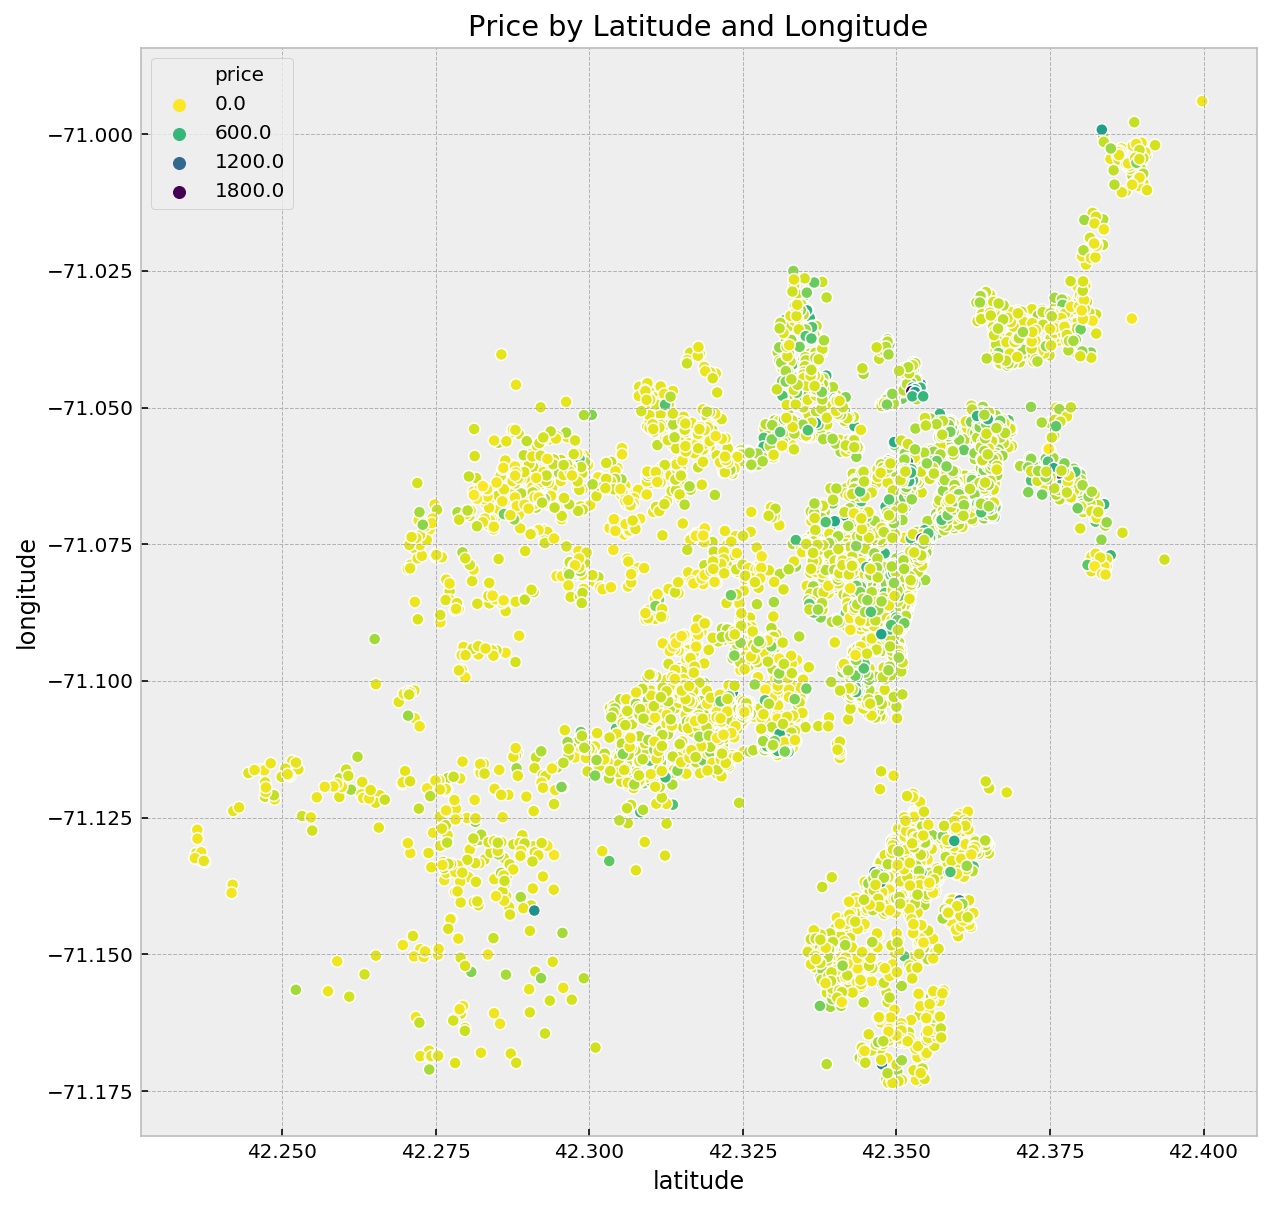

In [13]:
# Most price values are below 2000, so we will look at this range only
small_df = df[df.price < 2000]
plt.figure(figsize=(10,10))
sns.scatterplot(x='latitude', y='longitude', hue='price', data=small_df, palette='viridis_r')
plt.title('Price by Latitude and Longitude')

# EDA

### Univariate

In [14]:
df = pd.read_csv('../data/listings.csv')

In [15]:
for c in ['cleaning_fee', 'security_deposit', 'price', 'extra_people']:
    df[c] = df[c].replace('[^a-zA-Z0-9]', '', regex=True).apply(lambda x: float(x) / 100)

In [16]:
df.price.describe()

count    6296.000000
mean      196.547332
std       357.437717
min         0.000000
25%        80.000000
50%       147.000000
75%       219.000000
max      5000.000000
Name: price, dtype: float64

Text(0, 0.5, 'Frequency')

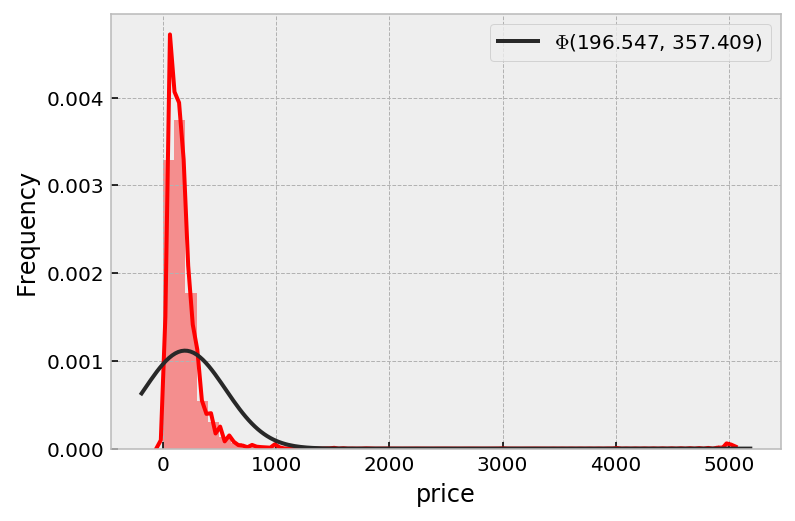

In [17]:
sns.distplot(df['price'], fit=norm, color='r')
(mu, sigma) = norm.fit(df['price'])

plt.legend([f'$\Phi$({mu:.3f}, {sigma:.3f})'], loc='best')
plt.ylabel('Frequency')

In [18]:
print('Skewness:', df['price'].skew())
print('Kurtosis:', df['price'].kurt())

Skewness: 11.391032902496246
Kurtosis: 147.2415811749089


Text(0, 0.5, 'Frequency')

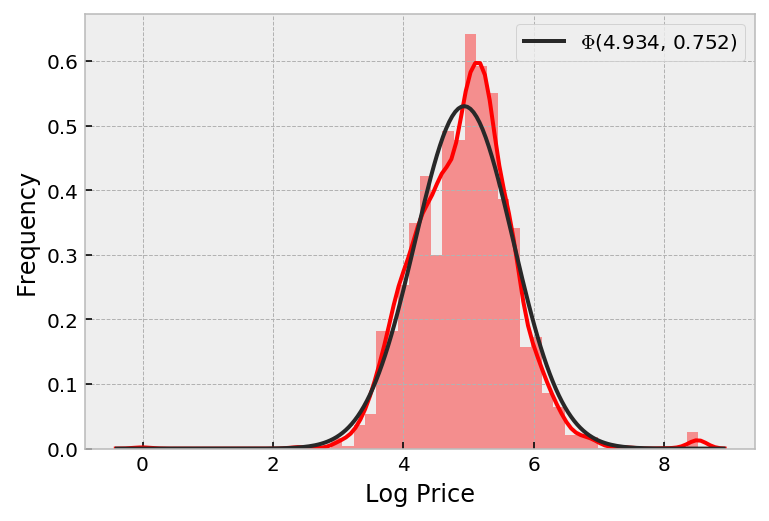

In [19]:
log_price = np.log1p(df.price)
sns.distplot(log_price, fit=norm, color='r')
(mu, sigma) = norm.fit(log_price)

plt.legend([f'$\Phi$({mu:.3f}, {sigma:.3f})'], loc='best')
plt.xlabel('Log Price')
plt.ylabel('Frequency')

In [20]:
print('Skewness:', log_price.skew())
print('Kurtosis:', log_price.kurt())

Skewness: 0.26206862222534555
Kurtosis: 2.804672466569365


### Bivariate

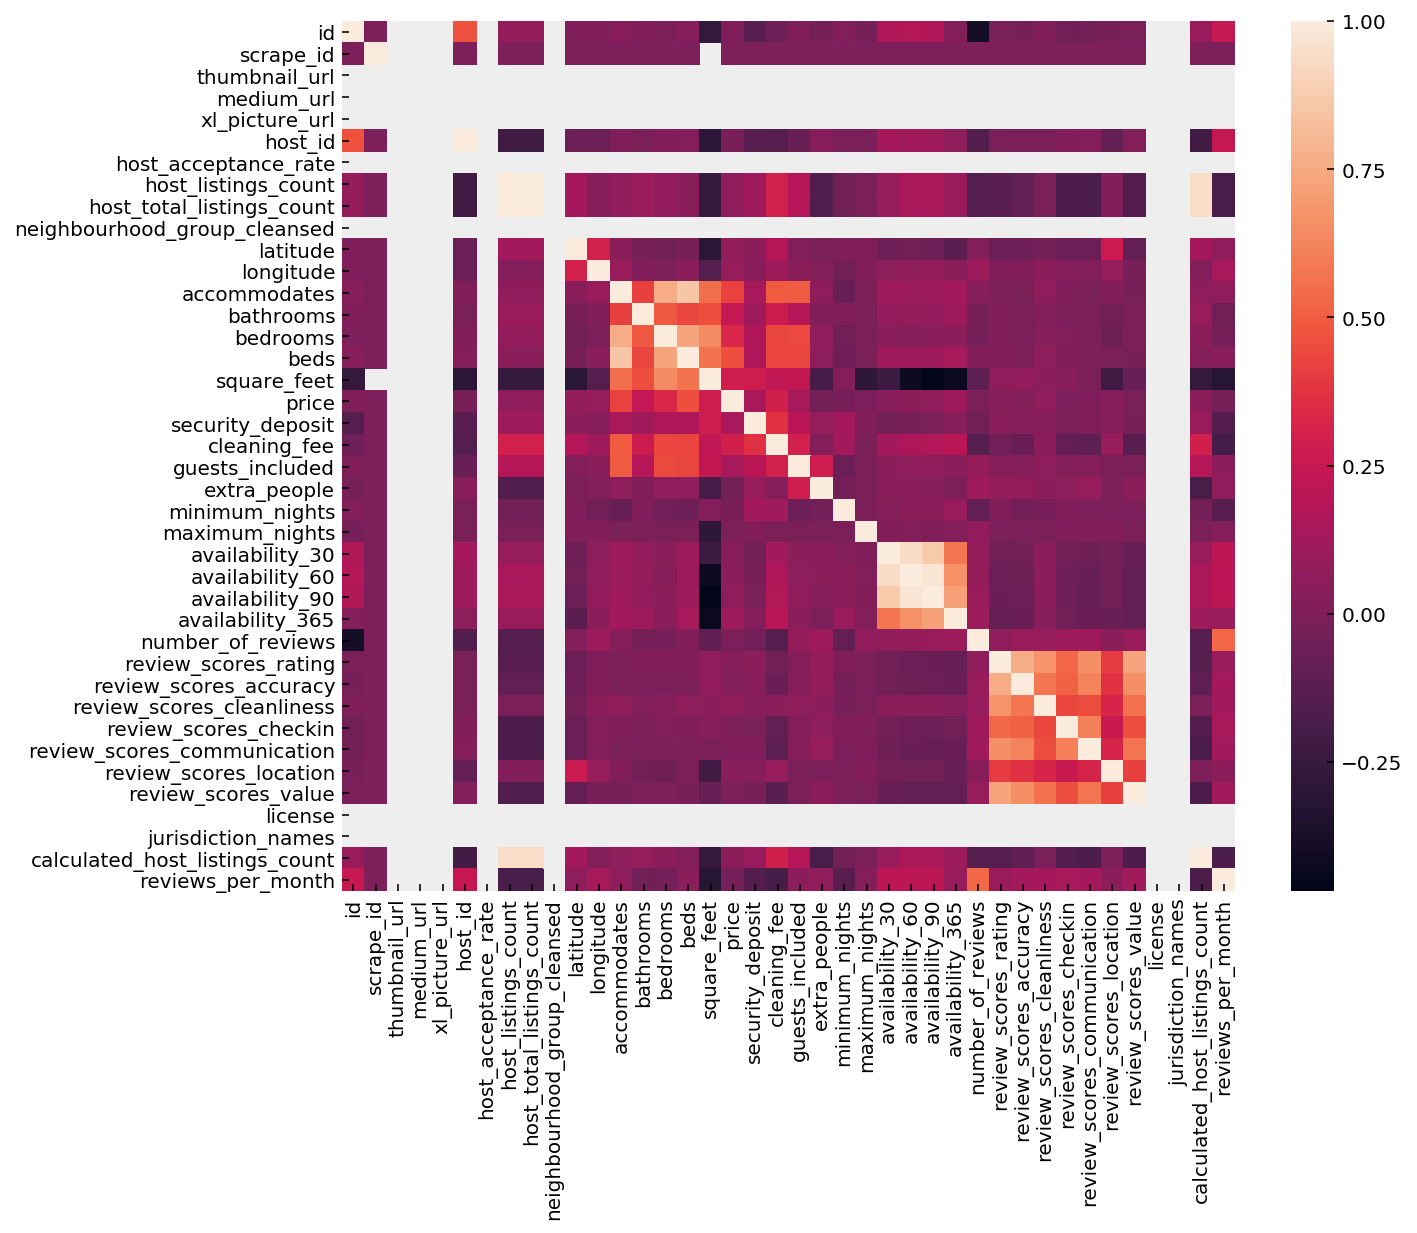

In [21]:
plt.figure(figsize=(10,8))
corr_mat = df.corr()
sns.heatmap(corr_mat)

Comments:
1. Host_listings_count, host_total_listings_count, and calculated_host_listings_count are duplicates
2. Availability features are highly-correlated

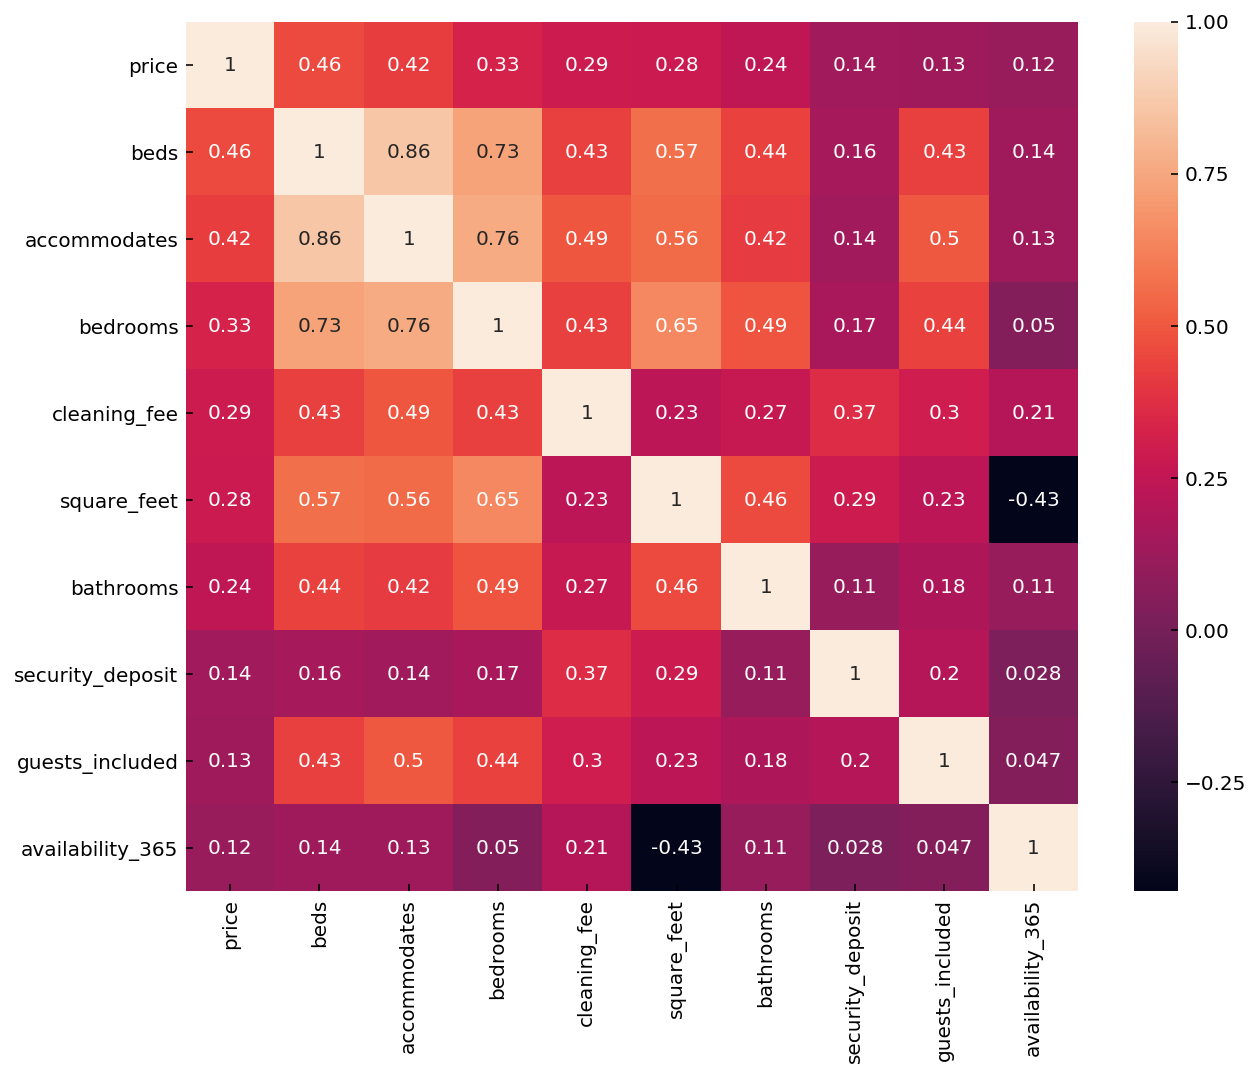

In [22]:
cols = corr_mat.nlargest(10, 'price')['price'].index
plt.figure(figsize=(10,8))
sns.heatmap(df[cols].corr(), annot=True)

/Users/hieunguyen/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/hieunguyen/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


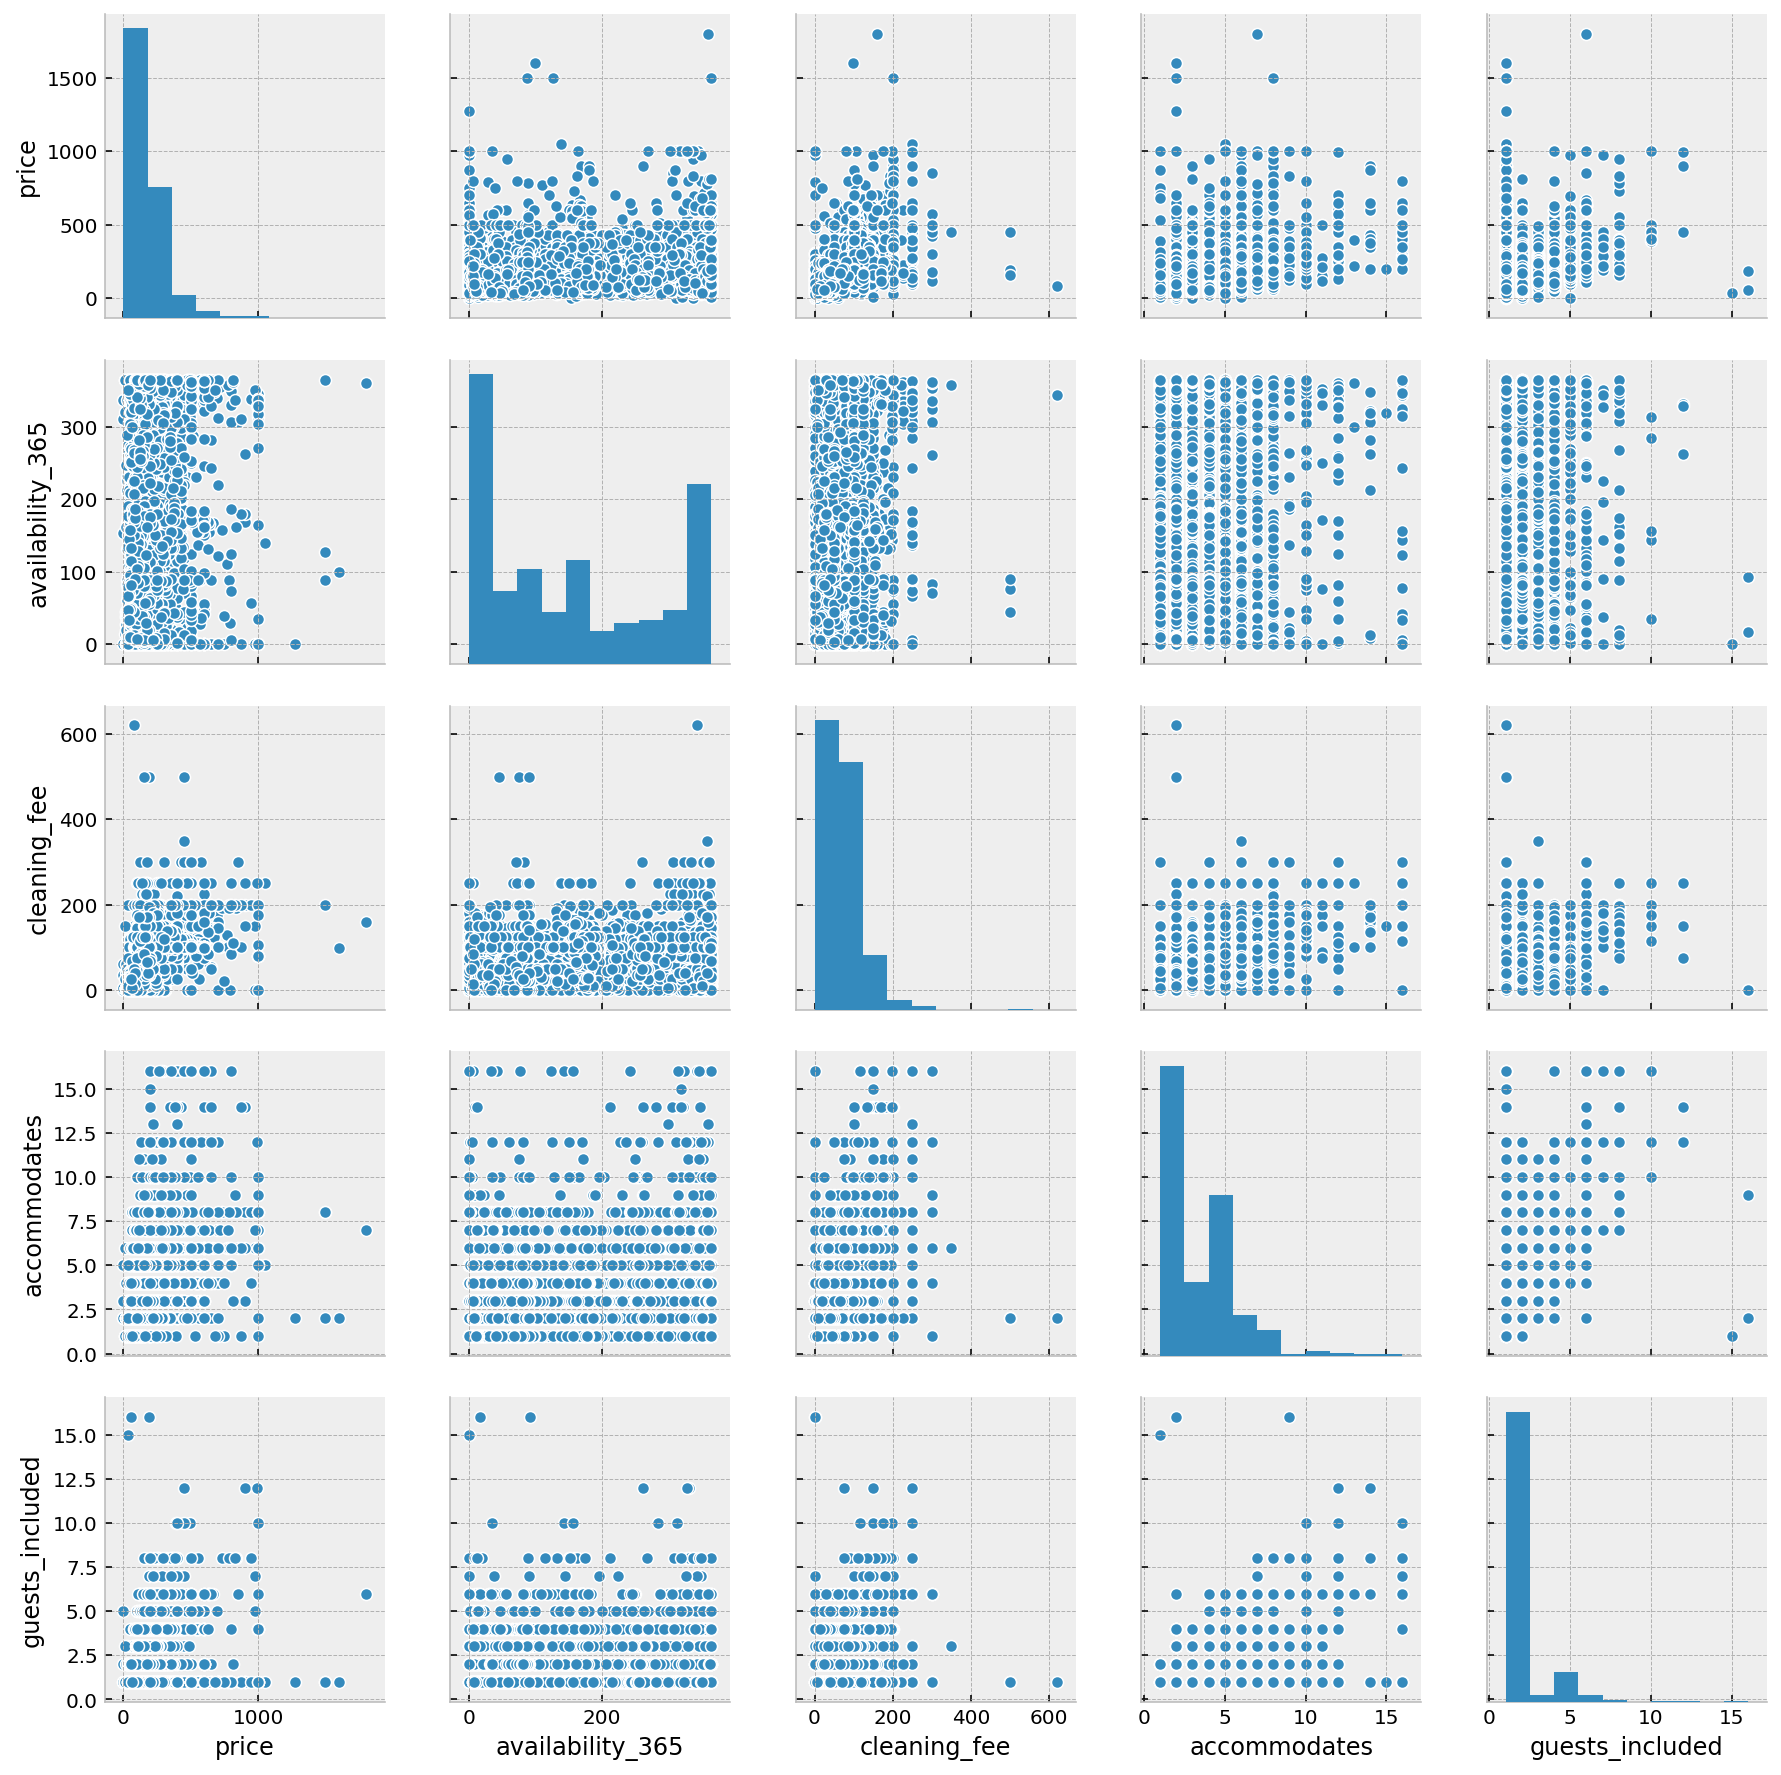

In [23]:
small_df = df[df['price'] < 2000]
small_df = small_df[['price', 'availability_365', 'cleaning_fee', 'accommodates', 'guests_included']]
sns.pairplot(small_df)

Comments: No clear trend between any features

# Feature Selection

#### Constant features and Binary features

In [24]:
df = pd.read_csv('../data/listings.csv')

In [25]:
for c in ['cleaning_fee', 'security_deposit', 'price', 'extra_people']:
    df[c] = df[c].replace('[^a-zA-Z0-9]', '', regex=True).apply(lambda x: float(x) / 100)

In [26]:
constant_feats = []
binary_feats = []
for c in df.columns:
    if df[c].nunique() <= 1:
        print(f'{c} has only {df[c].unique()}')
        constant_feats.append(c)
        
df.drop(constant_feats, axis=1, inplace=True)

scrape_id has only [20181117191239]
experiences_offered has only ['none']
thumbnail_url has only [nan]
medium_url has only [nan]
xl_picture_url has only [nan]
host_acceptance_rate has only [nan]
neighbourhood_group_cleansed has only [nan]
state has only ['MA' nan]
country_code has only ['US']
country has only ['United States']
has_availability has only ['t']
requires_license has only ['f']
license has only [nan]
jurisdiction_names has only [nan]
is_business_travel_ready has only ['f']


In [27]:
binary_feats = []
for c in df.columns:   
    if df[c].nunique() == 2:
        print(f'{c} has 2 values: {df[c].unique()}')
        binary_feats.append(c)

last_scraped has 2 values: ['2018-11-17' '2018-11-26']
host_is_superhost has 2 values: ['f' 't' nan]
host_has_profile_pic has 2 values: ['t' nan 'f']
host_identity_verified has 2 values: ['f' 't' nan]
market has 2 values: ['Boston' 'Other (International)' nan]
is_location_exact has 2 values: ['t' 'f']
calendar_last_scraped has 2 values: ['2018-11-17' '2018-11-26']
instant_bookable has 2 values: ['f' 't']
require_guest_profile_picture has 2 values: ['f' 't']
require_guest_phone_verification has 2 values: ['f' 't']


In [28]:
# Drop binary features that are not useful
df.drop(['last_scraped', 'market', 'calendar_last_scraped'], axis=1, inplace=True)

# Encode binary features
for c in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 
          'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']:
    # Fill NA with default
    df[c] = df[c].fillna('f')
    df[c] = df[c].map({'f':0, 't':1})

#### Other features

In [29]:
# for c in df.columns:   
#     if df[c].nunique() < 20 and df[c].nunique() > 2:
#         print(f'{c} has: {df[c].unique()}..of type: {np.dtype(df[c])}')

host_response_time has: ['within a day' nan 'within an hour' 'within a few hours'
 'a few days or more']..of type: object
room_type has: ['Entire home/apt' 'Private room' 'Shared room']..of type: object
accommodates has: [ 2  4  3  6  1  5  7 12  9 10  8 11 15 14 13 16]..of type: int64
bathrooms has: [1.  0.  3.  2.  1.5 nan 2.5 3.5 0.5 4.  4.5 5.  6. ]..of type: float64
bedrooms has: [ 1. nan  2.  0.  3.  4.  5.  6.  7.  8.]..of type: float64
beds has: [ 1.  2.  4.  3.  5.  6.  7.  8. nan 16.  9. 11. 10.  0. 12. 13. 17. 20.]..of type: float64
bed_type has: ['Real Bed' 'Couch' 'Futon' 'Pull-out Sofa' 'Airbed']..of type: object
guests_included has: [ 2  1  6  3  4  8 10  5 12  7 16 15]..of type: int64
review_scores_accuracy has: [10.  9.  8. nan  6.  7.  5.  4.  2.]..of type: float64
review_scores_cleanliness has: [10.  9. nan  8.  5.  4.  7.  2.  6.]..of type: float64
review_scores_checkin has: [10.  9. nan  8.  4.  7.  6.  5.  2.]..of type: float64
review_scores_communication has: [10

In [30]:
irrelevant_cols = [
    'id', 'listing_url', 'name', 'picture_url',
    'host_id', 'host_url', 'host_name', 'host_thumbnail_url', 
    'host_picture_url', 'host_neighbourhood', 'city', 'zipcode', 
    'smart_location','weekly_price','monthly_price', 'calendar_updated'
]

df.drop(irrelevant_cols, axis=1, inplace=True)

# host_location, street, neighbourhood can be implied from lat&long
# host_listings_count, host_total_listings_count highly correlate with calculated_host_listings_count
# 'availability_30', 'availability_60', 'availability_90' have high correlations with availability_365
high_corr_cols = ['host_location', 'street', 'neighbourhood',
                  'host_listings_count', 'host_total_listings_count',
                  'availability_30', 'availability_60', 'availability_90']
df.drop(high_corr_cols, axis=1, inplace=True)

# Missing Value

In [32]:
def plot_missing(df, as_perc=False, plot=True):
    missing_info = df.isnull().sum()
    missing_info = missing_info[missing_info > 0]
    if as_perc:
        missing_info = missing_info / df.shape[0]
    
    if plot:
        plt.barh(missing_info.index, missing_info.values)
        
    return missing_info

In [34]:
obj_df = df.select_dtypes('object')
numerical_cols = list(set(df.columns) - set(obj_df.columns))
numerical_df = df[numerical_cols]

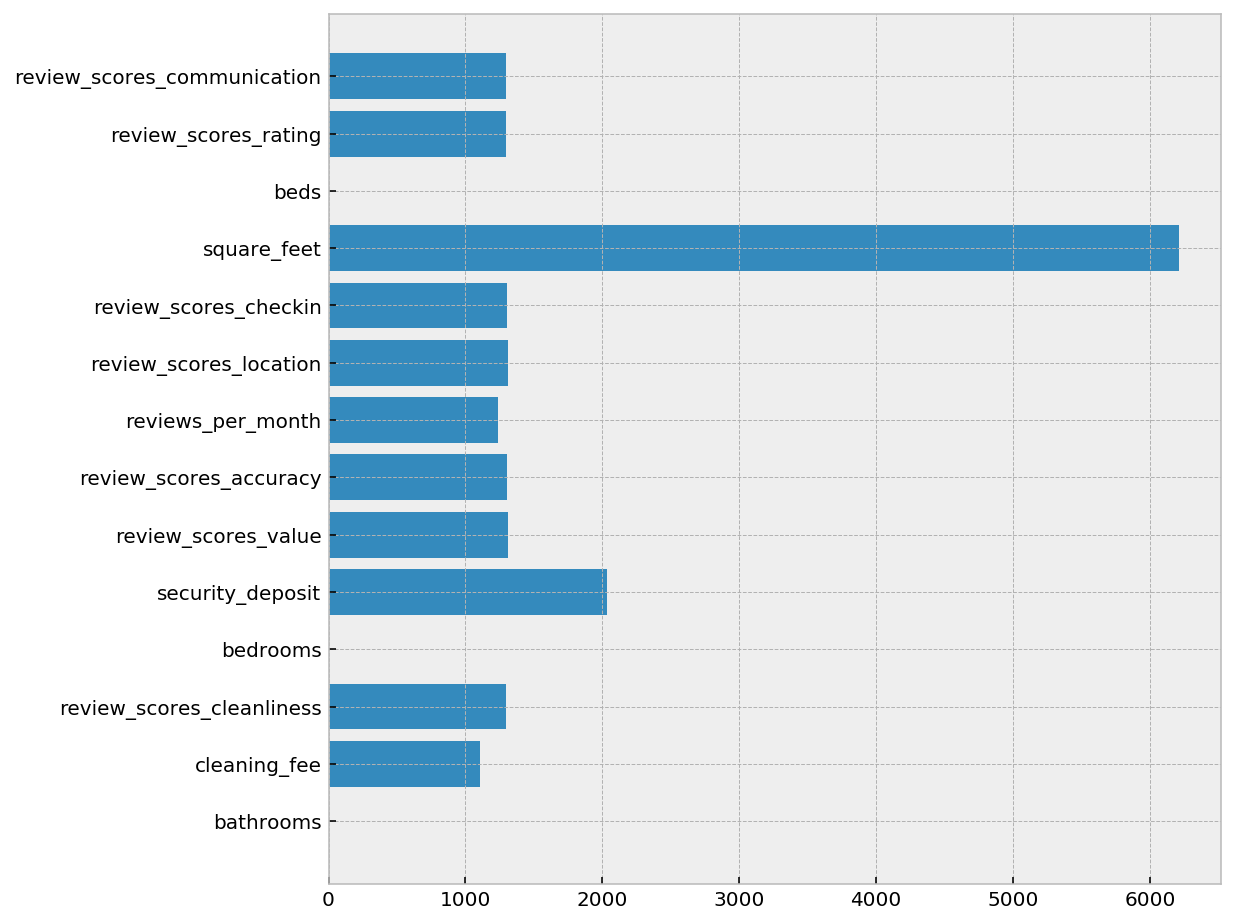

In [36]:
plt.figure(figsize=(8,8))
missing_info = plot_missing(numerical_df)

In [38]:
# square_feet has too many missing values
df.drop('square_feet', axis=1, inplace=True)

In [39]:
for c in ['beds', 'bathrooms', 'bedrooms']:
    df[c] = df[c].fillna(0)

In [40]:
# df['cleaning_fee'].hist()
df['cleaning_fee'] = df['cleaning_fee'].fillna(df['cleaning_fee'].median())

In [41]:
# df['security_deposit'].hist()
df['security_deposit'] = df['security_deposit'].fillna(df['security_deposit'].mode()[0])

In [42]:
# review_feats = [
#     'review_scores_rating', 'reviews_per_month', 'review_scores_location',
#     'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication',
#     'review_scores_accuracy', 'review_scores_value'
# ]

# _ = plot_missing(df[review_feats])

In [43]:
# review features should be imputed by sentiment analysis using some text features like description, notes.
# Here we temporarily drop them and use only review_scores_rating and impute it by median
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())

review_feats = [
    'reviews_per_month', 'review_scores_location', 'review_scores_checkin', 
    'review_scores_cleanliness', 'review_scores_communication',
    'review_scores_accuracy', 'review_scores_value'
]

df.drop(review_feats, axis=1, inplace=True)

#### Categorical Missing

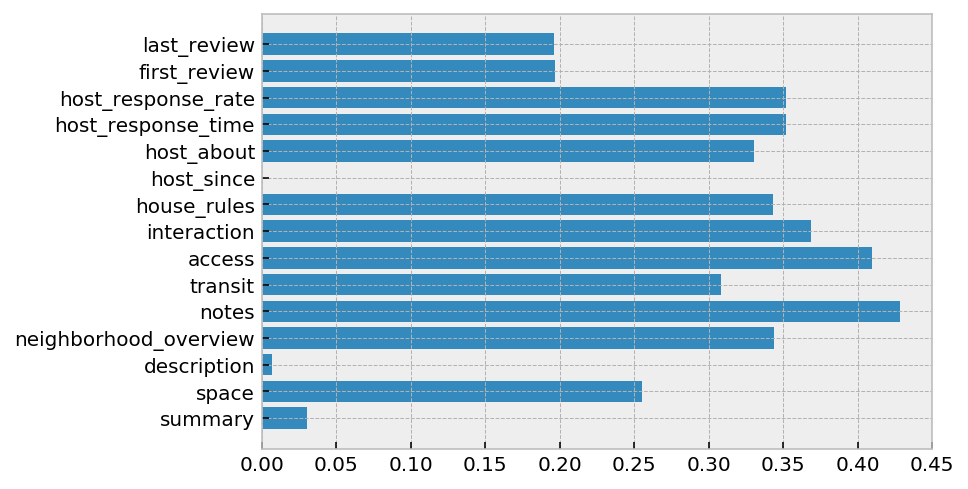

In [44]:
missing_info = plot_missing(df, as_perc=True)

In [45]:
to_transform = [
    'transit', 'access', 'notes', 'house_rules'
]

to_drop = [
    'summary', 'space', 'description', 'neighborhood_overview',
    'interaction', 'host_about',
]

df.drop(to_drop, axis=1, inplace=True)

In [46]:
df['host_response_rate'] = df['host_response_rate']\
                            .replace('[^a-zA-Z0-9^,]', '', regex=True)\
                            .apply(lambda x: float(x))

#df['host_response_rate'].hist()
df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].median())

In [47]:
d = { 
    'within an hour': 1, 
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4,
    'Longer': 5
}

df['host_response_time'] = df['host_response_time'].fillna('Longer')
df['host_response_time'] = df['host_response_time'].map(d)

In [48]:
for c in ['first_review', 'last_review', 'host_since']:
    df[c] = pd.to_datetime(df[c], format='%Y-%m-%d')

# Feature Engineering

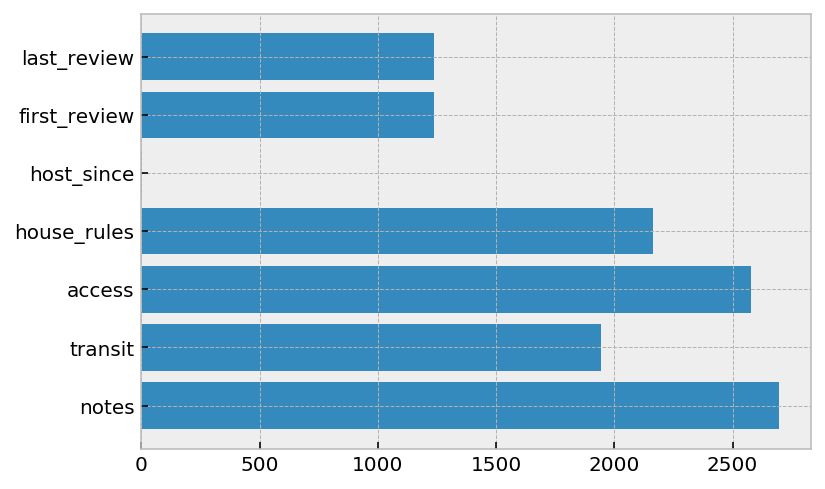

In [50]:
_ = plot_missing(df)

In [51]:
review_period = (df['last_review'] - df['first_review']).apply(lambda x: x.days)
review_period = review_period / 12
review_period = review_period.replace(0, review_period.median())

df['reviews_per_month'] = df['number_of_reviews'] / review_period
df['reviews_per_month'] = df['reviews_per_month'].fillna(df['reviews_per_month'].min())

df.drop(['last_review', 'first_review'], axis=1, inplace=True)

In [52]:
date_of_data = pd.to_datetime('17-11-2018', format='%d-%m-%Y')
df['host_since'] = (date_of_data - df['host_since']).apply(lambda x: x.days) / 12
df['host_since'] = df['host_since'].fillna(0)

In [53]:
# 'transit', 'access', 'notes', 'house_rules': tranform into binary features (whether one is mentioned in a listing).
# NaN means (by default) it's not
for c in to_transform:
    df[c] = df[c].notnull().astype(np.int)

df.drop(to_transform, axis=1, inplace=True)

In [57]:
df.select_dtypes('object').head()

,host_verifications,neighbourhood_cleansed,property_type,room_type,bed_type,amenities,cancellation_policy
0,"['email', 'phone', 'reviews']",East Boston,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",super_strict_30
1,"['email', 'phone', 'reviews', 'kba']",Roxbury,Guest suite,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",strict_14_with_grace_period
2,"['email', 'phone', 'reviews', 'kba']",Roxbury,Condominium,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",strict_14_with_grace_period
3,"['email', 'phone', 'reviews', 'jumio', 'govern...",Roslindale,Apartment,Private room,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",moderate
4,"['email', 'phone', 'reviews', 'jumio', 'offlin...",Downtown,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",strict_14_with_grace_period
5,"['email', 'phone', 'reviews', 'jumio', 'offlin...",Downtown,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",strict_14_with_grace_period
6,"['email', 'phone', 'reviews', 'jumio', 'govern...",South End,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",super_strict_30
7,"['email', 'phone', 'reviews', 'jumio', 'govern...",Back Bay,Serviced apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",super_strict_30
8,"['email', 'phone', 'reviews', 'jumio', 'govern...",Downtown,Serviced apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",super_strict_30
9,"['email', 'phone', 'reviews', 'jumio', 'govern...",Fenway,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",super_strict_30


In [58]:
for c in ['host_verifications', 'amenities']:
    df[c] = df[c].replace('[^a-zA-Z0-9^,]', '', regex=True).apply(lambda x: x.split(','))
    df[c] = df[c].apply(lambda x: len(x))

In [60]:
d = {  
    'super_strict_60' : 1, 
    'super_strict_30' : 2, 
    'strict_14_with_grace_period' : 3,
    'strict' : 4,
    'moderate' : 5,
    'flexible' :6
}

df['cancellation_policy'] = df['cancellation_policy'].map(d)

In [62]:
d = {
    'Entire home/apt' : 1, 
    'Private room' : 2, 
    'Shared room' : 3
}

df['room_type'] = df['room_type'].map(d)

In [64]:
df = pd.get_dummies(df, drop_first=True)
df.shape

(6296, 80)

# Modeling

In [65]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [76]:
X = df.drop('price', axis=1)
y = np.log1p(df['price'])

In [77]:
#Validation function
def rmsle_cv(model, n_folds, X_train, y_train):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def r2_cv(model, n_folds, X_train, y_train):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    r2 = cross_val_score(model, X_train.values, y_train, scoring="r2", cv = kf)
    return(r2)

In [78]:
models = {}
models['Lasso'] = Pipeline([('Scaler', RobustScaler()),
                            ('LASSO', Lasso(alpha =0.02, random_state=1))])

models['ElasticNet'] = Pipeline([('Scaler', RobustScaler()),
                                 ('EN', ElasticNet(alpha=0.02, l1_ratio=.9, random_state=3))])

model_xgb = xgb.XGBRegressor()

models['xgb'] = Pipeline([('Scaler', RobustScaler()), ('xgb', model_xgb)])

In [79]:
for name, model in models.items():
    score = rmsle_cv(model, 5, X, y)
    print(f"{name} score: {score.mean():.4f} ({score.std():.4f})\n")

Lasso score: 0.4985 (0.0491)

ElasticNet score: 0.4970 (0.0491)

xgb score: 0.4349 (0.0476)



In [80]:
for name, model in models.items():
    score = r2_cv(model, 5, X, y)
    print(f"{name} score: {score.mean():.4f} ({score.std():.4f})\n")

Lasso score: 0.5541 (0.0241)

ElasticNet score: 0.5568 (0.0240)

xgb score: 0.6616 (0.0133)



### Feature Importance

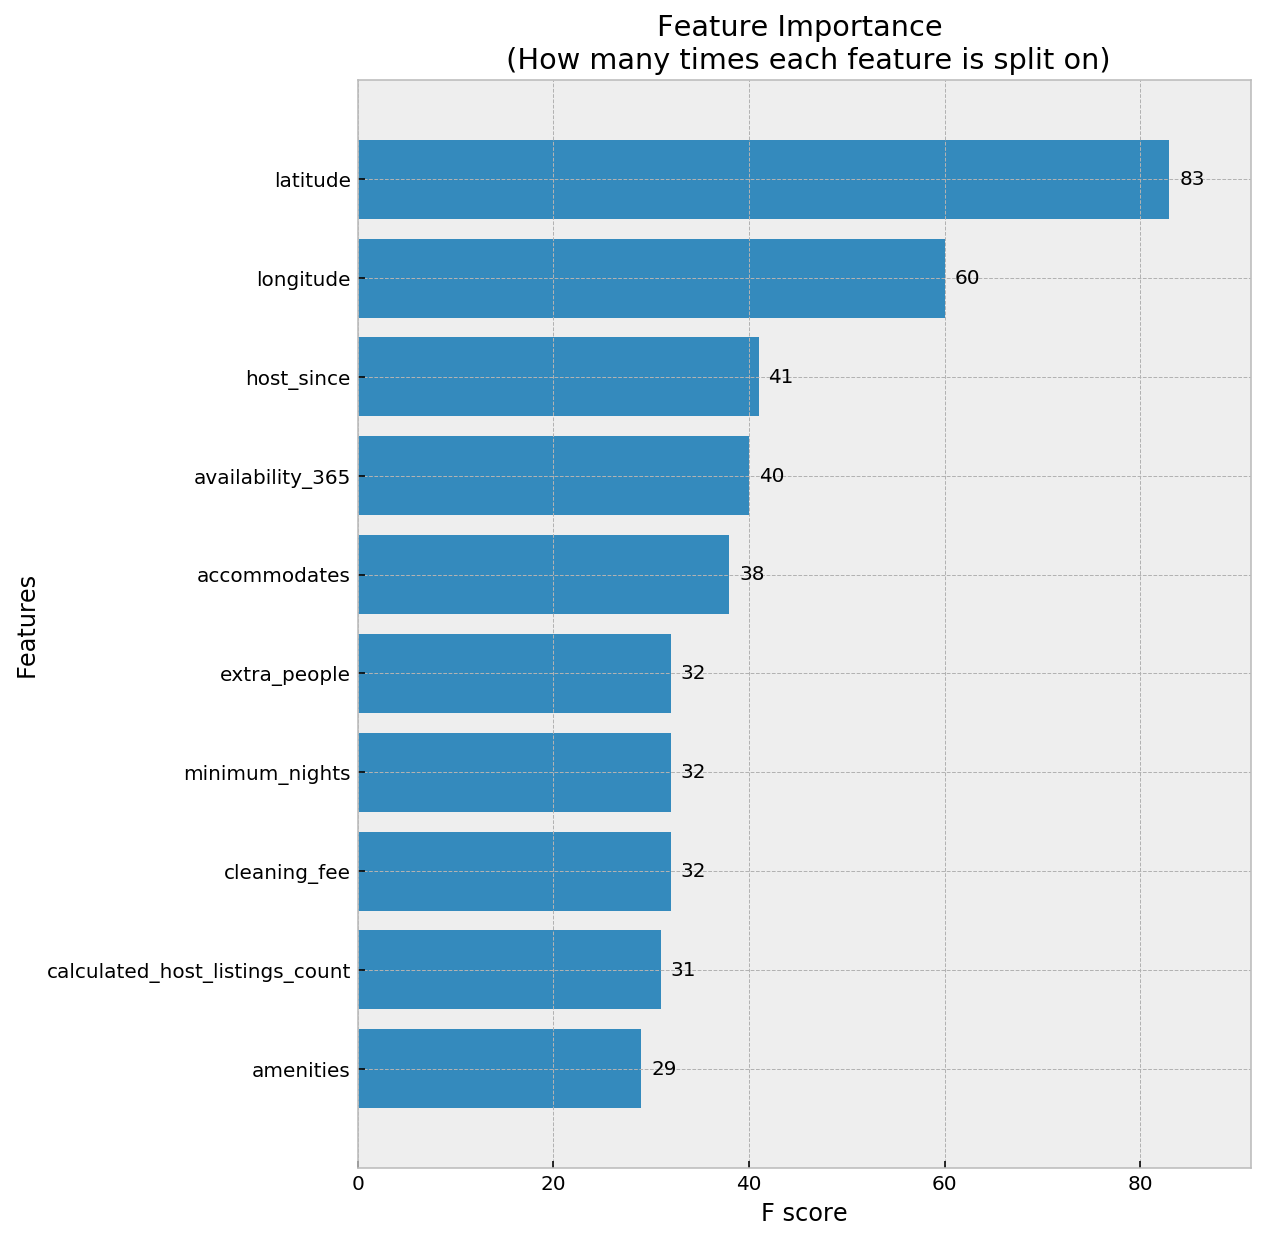

In [81]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X, y)

fig, ax = plt.subplots(figsize=(8, 10))
xgb.plot_importance(model_xgb, max_num_features=10, height=0.8, ax=ax)
plt.title('Feature Importance \n (How many times each feature is split on)')
plt.show()